# Zcash Turnstile
[Noncesense](https://noncesense.org) study by [Mitchell/Isthmus](https://www.github.com/mitchellpkt)

Modeling [ZIP308](https://github.com/zcash/zips/pull/197)

```
The amount to send in each transaction is chosen according to the 
following distribution:

1. Choose an integer exponent uniformly in the range 6 to 9 inclusive.
2. Choose an integer mantissa uniformly in the range 1 to 99 inclusive.
3. Calculate amount := (mantissa * 10:sup:`exponent`) zatoshi.
4. If amount is greater than the amount remaining to send, repeat from step 1.
```

## Set Parameters

In [1]:
num_rolls = 50000000 # How many samples
num_bins = 500

## Import libraries

In [2]:
import random as random
import matplotlib.pyplot as plt
import numpy as np
from pylab import subplot

In [3]:
%matplotlib inline

## Simulate

In [4]:
val_list = []
for i in range(num_rolls):
    exponent = random.randint(3,6)
    mantissa = random.randint(1,99)
    value = mantissa*10**exponent
    val_list.append(value)

## Plot

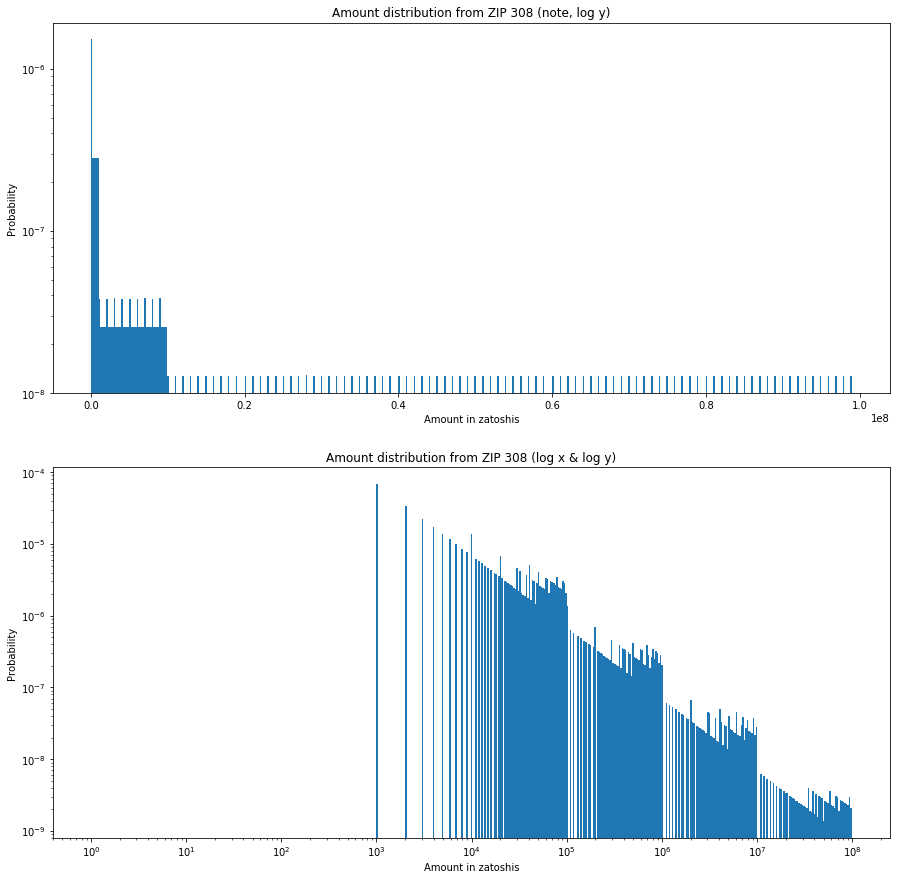

In [5]:
junk = plt.figure(figsize=(15,15),facecolor='white')

subplot(2,1,1)
plt.hist(val_list, density=1, bins=num_bins)
plt.title('Amount distribution from ZIP 308 (note, log y)')
plt.yscale('log')
plt.ylabel('Probability');
plt.xlabel('Amount in zatoshis\n');

subplot(2,1,2)
log_bins = 10 ** np.linspace(np.log10(1), np.log10(99*10**6), num_bins)
plt.hist(val_list, density=1, bins=log_bins)
plt.title('Amount distribution from ZIP 308 (log x & log y)')
plt.ylabel('Probability');
plt.xlabel('Amount in zatoshis');
plt.xscale('log')
plt.yscale('log')